# Chapter 8: Dimensionality Reduction

Two primary approaches

* Projection
    * Most high-dimensionality data sets are highly correlated along some axes. Meaning they actually (to a reasonable approximation) can be isolated to some subspace of the higher-dimensional space
* Manifold learning
    * Sometimes the subspace is actually best represented as a manifold
    * A manifold is a structure that _locally resembles_ a hyperplane. (For example a 2D plane rolled or twisted in 3D space)
    * Manifold learning models the manifold on which the datapoints lie
    
While dimensionality reduction usually simplifies training, it doesn't always result in a better model

## PCA

* Identifies hyperplane and projects data onto i
* Picks the hyperplane that preserves the greatest degree of variance among projected points
    * Specifically minimizes the mean squared distance between original and projected data points
    
* PCA identifies the axes that hold the most variance along the data, sequentially
    * The unit vector that defines the ith axis is the ith principal component    
    * Can find PCs through Singular Value Decomposition (SVD)
        * Decomopses a matrix into the dot product of three matrices
        \begin{align}
        \large
        \mathbf{U \cdot \Sigma \cdot V}^T
        \end{align}
        * V contains all the principal components

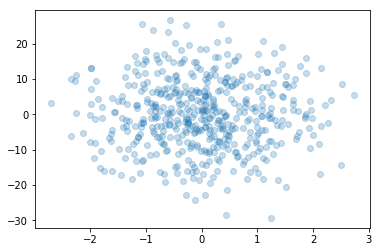

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

x = np.random.randn(1000).reshape((500,2))
x[:,1] = x[:,1] * 10

# Center around (0,0). Usually taken care of you in sklearn
x_cent = x - x.mean(axis = 0)
plt.scatter(x_cent[:,0], x_cent[:,1], alpha = 0.25)
plt.show()



[[ 0.00227839 -0.9999974 ]
 [ 0.9999974   0.00227839]]


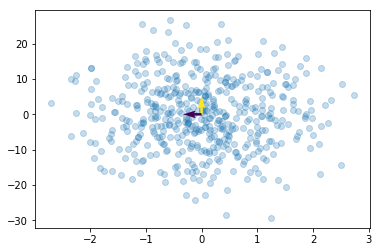

In [24]:

U, s, Vt = np.linalg.svd(x_cent)

# Two Principal
print(Vt)

plt.scatter(x_cent[:,0], x_cent[:,1], alpha = 0.25)
plt.quiver((0,0), (0,0), Vt[0,:], Vt[1,:], (1,0))
plt.show()

In [30]:
w2 = Vt.T[:, :1]
w2

array([[ 0.00227839],
       [-0.9999974 ]])

In [32]:
x2d = x_cent.dot(w2)
x2d.shape

(500, 1)

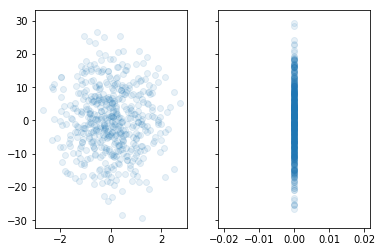

In [48]:
# Add y = 0 for plotting
# x2plot = np.c_[x2d, np.zeros_like(x2d)]
# x2plot.shape

f, (ax1, ax2) = plt.subplots(1,2, sharey = True)
ax1.scatter(x_cent[:,0], x_cent[:,1], alpha = 0.1)
ax2.scatter(np.zeros_like(x2d), x2d, alpha = 0.1)
ax1.set_title("2D Data")
ax2.set_title("1D Projection")
plt.show()

This reverses the axis as the pc used is negative

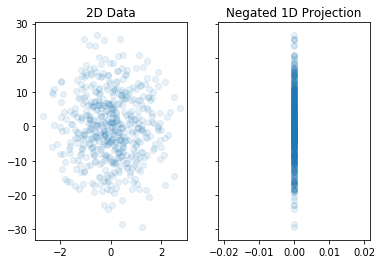

In [51]:
f, (ax1, ax2) = plt.subplots(1,2, sharey = True)
ax1.scatter(x_cent[:,0], x_cent[:,1], alpha = 0.1)
ax2.scatter(np.zeros_like(x2d), -x2d, alpha = 0.1)
ax1.set_title("2D Data")
ax2.set_title("Negated 1D Projection")
plt.show()

Negate collapsed values to get true correspondance. 

In [55]:
# Using sklearn's method

from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
x2d_pca = pca.fit_transform(x2d)
x2d_pca.shape

(500, 1)

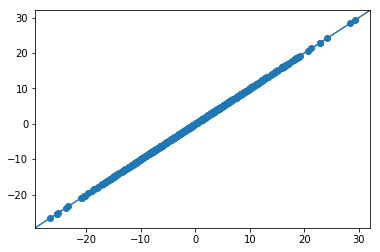

In [57]:
# Show results are identical
def abline():
    gca = plt.gca()
    gca.set_autoscale_on(False)
    gca.plot(gca.get_xlim(),gca.get_ylim())

plt.scatter(x2d, x2d_pca)
abline()
plt.show()

In [58]:
pca.explained_variance_ratio_

array([1.])

For visualization, reduce to 2 or 3 dim.

For other purposes, usually want to reduce down to a dim number that captures some amount of variance

In [119]:
from sklearn import datasets

x, y = datasets.make_swiss_roll(1000)

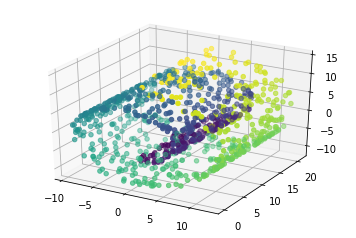

In [121]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c = y)
plt.show()

In [154]:
# Find the number of dims that captures 95% of variance
from sklearn.datasets import make_regression

x, y = make_regression(10000, 1000, 50)
print("X: ", x.shape)
print("Y: ", y.shape)

X:  (10000, 1000)
Y:  (10000,)


In [155]:
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
# cumsum

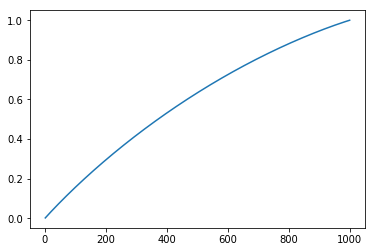

In [156]:
plt.plot(np.arange(0, cumsum.shape[0]) + 1, cumsum)
plt.show()


In [157]:
d = np.argmax(cumsum >= 0.95) + 1
d

908

In [153]:
# Can set n_components to a value 0 - 1 to designate how much variance to capture

pca = PCA(n_components= 0.95)
x_red = pca.fit_transform(x)
x_red.shape

(1000, 91)

Can use pca.inverse_transorm to reconstruct original data. The data loss in this process is called the _reconstruction error_.

## Incremental PCA

Allows you to train a PCA in batches, allowing the algorithm to operate out of memory.

In [173]:
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata


digits = fetch_mldata('MNIST original')

x, y = digits['data'], digits['target']
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


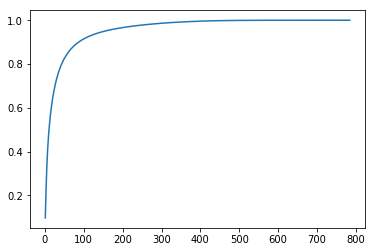

In [174]:
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(0, cumsum.shape[0]) + 1, cumsum)
plt.show()

In [ ]:
d = np.argmax(cumsum >= 0.95)

In [218]:
from sklearn.decomposition import IncrementalPCA


var_dim = np.argmax(cumsum >= 0.95) + 1
print("Reducing to ", var_dim, " dimensions.")
n_batches = 100
inc_pca = IncrementalPCA(n_components = var_dim)

for x_batch in np.array_split(x, n_batches):
    inc_pca.partial_fit(x_batch)
    
x_red = inc_pca.transform(x)
print(x.shape, x_red.shape)

Reducing to  154  dimensions.
(70000, 784) (70000, 154)


In [222]:
x_recon = inc_pca.inverse_transform(x_red)
x_recon.shape

(70000, 784)

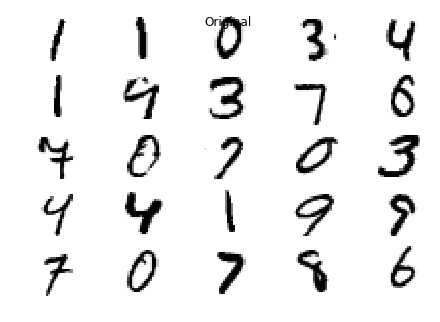

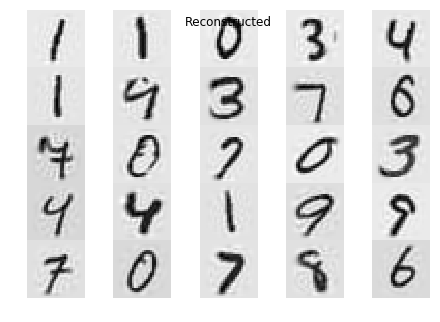

In [235]:
plot_dims = 5
to_plot = np.random.randint(0, x.shape[0], plot_dims ** 2)

def plotDigit(ardig):
    ardig_img = ardig.reshape((28,28))
    plt.imshow(ardig_img, cmap = matplotlib.cm.binary, interpolation = "nearest")
    
def plotDigitSet(digit_set, plot_dim):
    for i, n in enumerate(digit_set):
        plt.subplot(plot_dim, plot_dim, i + 1)
        plotDigit(n)
        plt.axis('off')
        
plotDigitSet(x[to_plot,:], plot_dims)
plt.suptitle("Original")
# plt.tight_layout()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

# plotDigitSet(x_red[to_plot,:], plot_dims)
# plt.title("Reduced")
# plt.show()

plotDigitSet(x_recon[to_plot,:], plot_dims)
plt.suptitle("Reconstructed")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()
        
        

Can also use a stochastic method with a faster training time. Set `svd_solver = "randomized"` when constructing PCA.

## Kernel PCA

Uses kernel trick to project data into higher dimensionality before reducing. Can sometimes preserve more information by collapsing data along complex manifolds.



In [236]:
from sklearn.decomposition import KernelPCA

x, y = datasets.make_swiss_roll(1000)

rbf_pca = KernelPCA(n_components = 2, kernel = "rbf", gamma = 0.04)
x_red = rbf_pca.fit_transform(x)

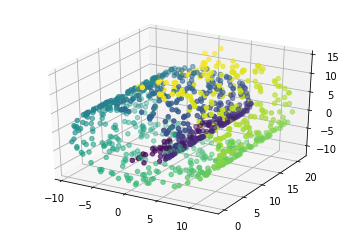

In [239]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c = y)
plt.show()

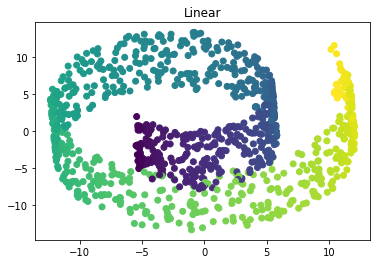

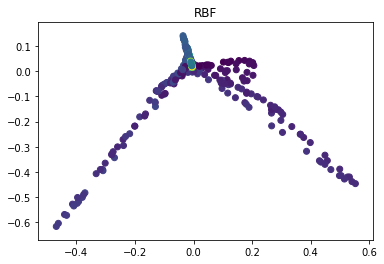

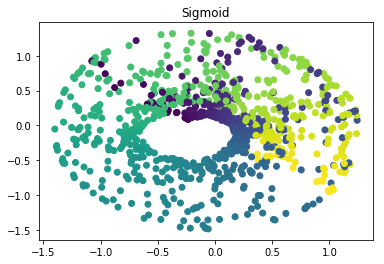

In [256]:
def pca_by_kernel(mx, my, kern, title):
    kern_pca = KernelPCA(n_components= 2, kernel = kern)
    x_red = kern_pca.fit_transform(x)
    plt.scatter(x_red[:,0], x_red[:,1], c = y)
    plt.title(title)
    plt.show()
    
pca_by_kernel(x, y, "linear", "Linear")
pca_by_kernel(x, y, "rbf", "RBF")
pca_by_kernel(x, y , "sigmoid", "Sigmoid")

As PCA is unsupervised, finding the optimal kernel and paramaters requires using a pipeline with a grid search.

In [261]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
# grid_search.fit(x, y)

Can also try several that minimize the reconstruction error. Using a kernel makes this calculation impossible to do exactly. Can instead train a supervised regression model with the reduceded data as training data and the original data as targets. Can be done automatically with sklearn

In [262]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
# X_reduced = rbf_pca.fit_transform(X)
# X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error

# mean_squared_error(X, X_preimage)

## Locally Linear Embedding (LLE)

Powerful nonlinear dimensionality reduction (NLDR) algorithm.

"In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise."

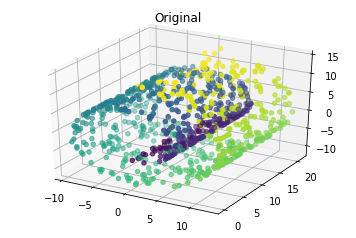

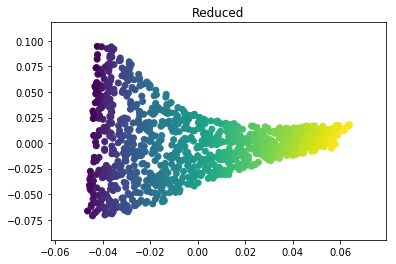

In [268]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)

x_red = lle.fit_transform(x)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c = y)
plt.title("Original")
plt.show()

plt.scatter(x_red[:,0], x_red[:,1], c = y)
plt.title("Reduced")
plt.show()

## Other Techniques

Multidimensional Scaling (MDS) reduces dimensionality while trying to preserve the distances between the instances (see Figure 8-13).

Isomap creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances9 between the instances.

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

Linear Discriminant Analysis (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.

## Exercises

1. What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

1. What is the curse of dimensionality?

1. Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

1. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

1. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

1. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?

1. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

1. Does it make any sense to chain two different dimensionality reduction algorithms?

9. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?

10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

In [269]:
## Exercise 9

digits = fetch_mldata('MNIST original')

x, y = digits['data'], digits['target']
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


In [271]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 10000)

In [285]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators= 500, max_leaf_nodes= 16, n_jobs= -1)
# rfc = RandomForestClassifier()
%time rfc.fit(train_x, train_y)




CPU times: user 2min 15s, sys: 2.89 s, total: 2min 17s
Wall time: 2min 25s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Unreduced takes 2min 25s

In [287]:
from sklearn.model_selection import cross_val_score

cross_val_score(rfc, train_x, train_y, cv = 3, scoring = "accuracy")

array([0.82588482, 0.82465   , 0.82576515])

In [289]:
# Do again using reduced data
pca = PCA(n_components=0.95)
x_red = pca.fit_transform(train_x)
%time rfc.fit(x_red, train_y)

CPU times: user 3min 54s, sys: 627 ms, total: 3min 54s
Wall time: 2min 4s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Reduced 2min 4s

In [291]:
cross_val_score(rfc, x_red, train_y, cv = 3, scoring = "accuracy")

array([0.80918816, 0.8108    , 0.81316263])

In [292]:
x_red.shape

(60000, 154)

Reducing from 784 to 154 dimensions reduces training time from 2:25 to 2:04 and reduces accuracy minimally (0.82 to 0.81)

In [ ]:
## Exercise 10

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
x_tsne = tsne.fit_transform(train_x)

Note: TSNE took sooooooo long omg

In [ ]:
plt.scatter(x_tsne[:,0], x_tsne[:,1], c = y)
plt.title("t-SNE Reduced MNIST Digits")
plt.show()